PROBLEMATIQUE DE NOTRE ETUDE:
# “How can the European bank identify and predict key factors driving customer churn, and what strategies can be implemented to reduce churn based on customer profiles and behavior patterns?”

In [122]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 

import os
os.getcwd
# from FUNCTIONS import plot_density 

<function posix.getcwd()>

In [155]:
df_full = pd.read_csv("churn_bank.csv") # if already in the repo, otherwise use the full path

df_exited = df_full.loc[df_full['Exited'] == 1]
df_germany = df_full.loc[df_full['Geography'] == "Germany"]

As we saw in the first part of the analysis, around 20% of the overall customers have exited the bank. In the following part we try to identify and predict key factors driving customers churn. In this way banks can possibly reduce this number based on customer profiles and behavior patterns. 

# Correlation analysis

We first try to get an idea of the possible variables that can be correlated with churning (our Exited variable). To do so we build a correlation matrix to see what might affect churn. 

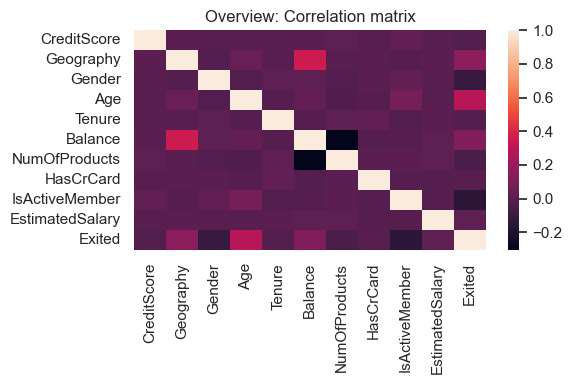

In [156]:
# correlation matrix only takes numerical values not string. 
# therefore we transform the Geography and Gender as numerical values (dummies).
COUNTRY = {"France":"1",
        "Spain":"2",
        "Germany":"3"}
GENDER = {"Female":"1",
        "Male":"2"}

df_corr = df_full.copy()
df_corr.replace({'Geography': COUNTRY, 'Gender': GENDER}, inplace=True) 

df_corr = df_corr.drop(columns=["Surname", "CustomerId"])
# computing it
matrix_corr = df_corr.corr()
# plotting
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(matrix_corr)
# title and axis labels
ax.set(
    title="Overview: Correlation matrix"
)

# save the figs for LATEX 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/CorrelationMatrix_1.png')

Strongest correlation

- Geography - Exited. 
- Age - Exited. 
- Balance - Exited 
   
Not directly correlated to churn but studied in the first part: 

- Balance - Geography  
Maybe the balance = 0 est concentré plus dans un pays que dans les autres)
- Nbr of products - Exited (mais very little et ça peut être du au très faible nombre de customer avec 3 ou 4 products)
- Age - Is active member (very little aussi mais à check) 

# Customer profile: Geography, Age and Gender

### AGE

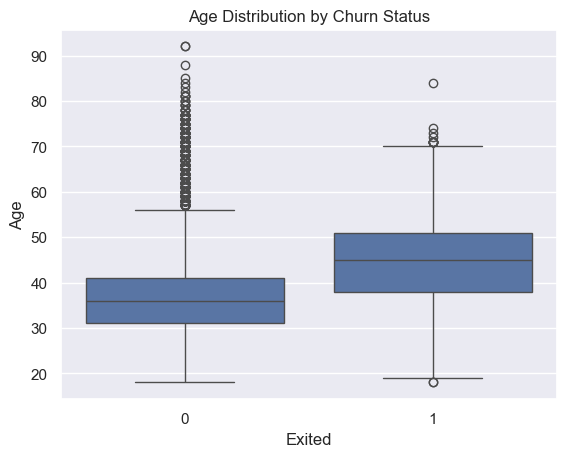

<Figure size 640x480 with 0 Axes>

In [157]:
# MAIN 
    # 1. How does Age interactw with churn ? 

sns.boxplot(x='Exited', y='Age', data=df_full) 
plt.title('Age Distribution by Churn Status') 
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Age_distribution.png')

- Seems like Customers who churned are generally older, with the median age being higher compared to non-churned customers. 
- The Interquartile Range (25th percentile - 75th percentile) seem larger for churned customers: more variability in their ages compared to non-churned customers. [not churn : most ages fall between roughly 30 and 45. churned : most ages are between approximately 45 and 60.]
- A lot of outliers for the non-churned one at older age. Some older customers stayed, they are not representative of the typical customer who did not churn?
- Customers who did not churn have a more concentrated age range (roughly 20 to 55), while customers who churned have a wider range, spreading from about 20 to 70 et plus.

Overall : older customers appear more likely to churn (comme on le voit avec the higher median age and the wider age distribution in the churned group). + Non-churned customers are generally younger, with a more concentrated age range, suggesting that the bank may be more successful in retaining younger clients.
We see that non-churned customers are generally younger, with a more concentrated age range around 30-40 years old, which could come from the fact that, as we showed previously, the dataset is composed mainly of younger customers. However, on the side of the churned customers there's seems to be a pattern with older customers that appear more likely to exit the bank (see ANNEX. we indeed see that the churn rate is the highest for the age group [50;60] years old). This suggest that the bank may be more successful in retaining/attracting younger clients.


/var/folders/rz/f98wb9gj7vz0bnm2ntxmyv3m0000gn/T/ipykernel_95514/1790678236.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean()


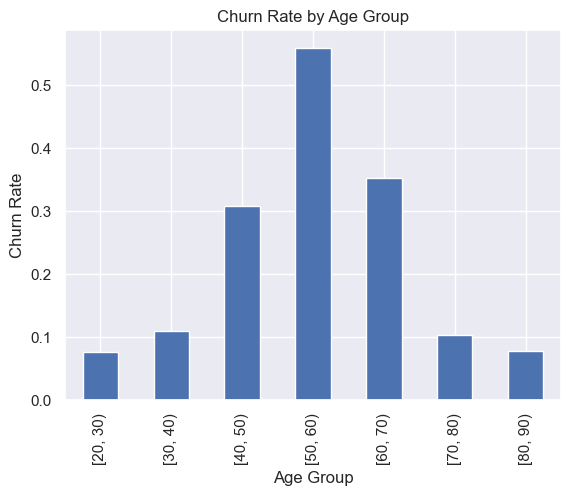

<Figure size 640x480 with 0 Axes>

In [158]:
# ANNEX 
    # Create age groups (e.g., bin ages into 10-year intervals)

df_full['Age_group'] = pd.cut(df_full['Age'], bins=[20, 30, 40, 50, 60, 70, 80, 90], right=False) 
# Calculate churn rate per age group 
churn_rate_by_age = df_full.groupby('Age_group')['Exited'].mean() 
churn_rate_by_age.plot(kind='bar') 
plt.title('Churn Rate by Age Group') 
plt.ylabel('Churn Rate') 
plt.xlabel('Age Group') 
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Age_Group_churn.png')

In [159]:
## this part is more prediction - logisitc regression model

df_split_age_top = df_full.loc[df_full['Age'] >= 50]

#####

X = df_split_age_top[['Age']] 
y = df_split_age_top['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = LogisticRegression() 
model.fit(X_train, y_train) 

# show how much age influences churn
print(f"Coefficient for Age: {model.coef_[0][0]}")



Coefficient for Age: -0.10278123465246204


In [160]:
######

df_split_age_bottom  = df_full.loc[df_full['Exited'] <= 50]

X = df_split_age_bottom[['Age']] 
y = df_split_age_bottom['Exited'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

model = LogisticRegression() 
model.fit(X_train, y_train) 

# show how much age influences churn
print(f"Coefficient for Age: {model.coef_[0][0]}")


Coefficient for Age: 0.06274384470379325


Holding all else constant, for every 1 year increase in age, the (log?)odds of a customer churning increases by almost 6.5% (cause log) - in lign with the above results showing that older customers are more likely to churn. 

------- ## let's try to add to the regression: dummy 1 for above 50 and a dummy 2 under 50 -- see how it looks. 

### COUNTRY

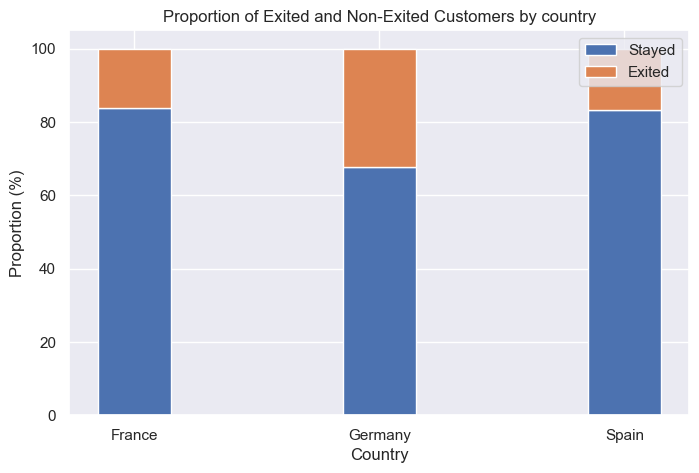

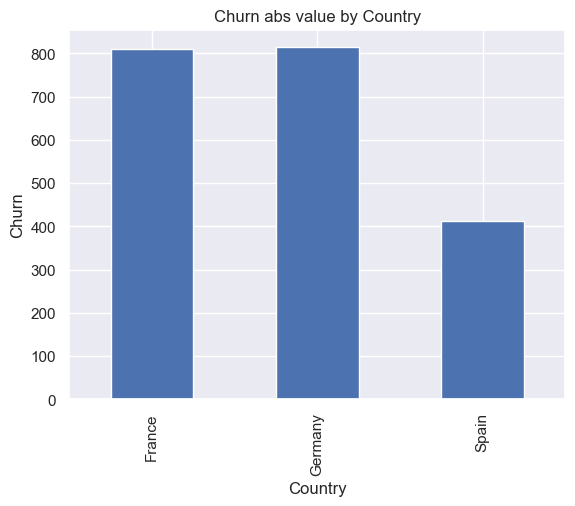

<Figure size 640x480 with 0 Axes>

In [161]:
# MAIN 
    # 2. How does Geography interacts with churn ? 
    # in relative terms, relative comparison : 
df_geo_exit = (df_full
      .groupby("Geography")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_geo_exit.index, df_geo_exit[0], label = 'Stayed', width = 0.3) 
ax.bar(df_geo_exit.index, df_geo_exit[1], bottom = df_geo_exit[0], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by country",
    xlabel = "Country",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Country_churn_perc.png')

    # in absolute count, total number of customers who exited : 
df_full[df_full['Exited'] == 1].groupby('Geography')['Exited'].count().plot(kind='bar') 
plt.title('Churn abs value by Country') 
plt.ylabel('Churn') 
plt.xlabel('Country') 
plt.show() # ANNEX
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Country_churn_absvalue.png')



First chart: gives a relative comparison WITHIN each country. within germany the proportion of customers exiting is higher relative to the total population 
Keeping in mind (as showed in the ANNEX) that in absolute we see that the same number of customers exit the bank in France and Germany. 
Given that germany has acomparable number of customers than spain, and twice less customer than france it might be interesting to further look at what might explain the bigger proportion of churning in this country. 

The relatively strong correlation we found in the correlation matrix between geography and exited might be explained by the significant difference in percentage of exit in Germany. 


### GENDER

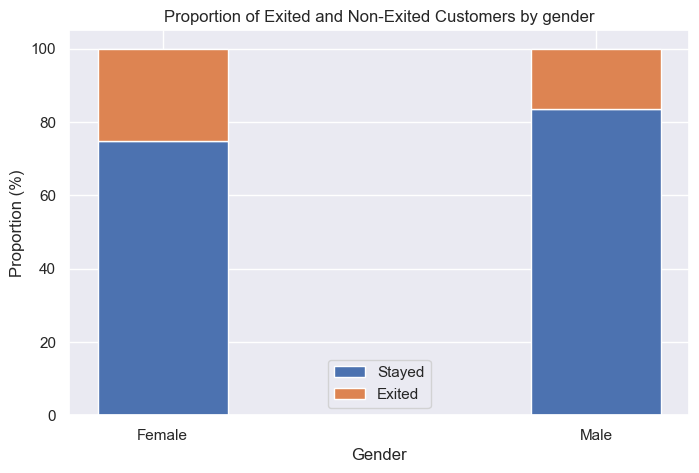

<Figure size 640x480 with 0 Axes>

In [162]:
# MAIN
    # What about gender ? 
df_gender_exit = (df_full
      .groupby("Gender")["Exited"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_gender_exit.index, df_gender_exit[0], label = 'Stayed', width = 0.3) 
ax.bar(df_gender_exit.index, df_gender_exit[1], bottom = df_gender_exit[0], label='Exited', width = 0.3)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by gender",
    xlabel = "Gender",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Gender_churn.png')
 

The percentage of female leaving the bank seem higher overall than for male. If we split by country we see the same results: in all the three countries the percentage of female churning over the full sample of churned customers per country, is always higher (see. table below)

In [163]:
     # simple summing and percentages
female_df = df_full[(df_full['Gender'] == "Female") & (df_full['Exited'] == 1)].groupby('Geography')['Gender'].count()
male_df = df_full[(df_full['Gender'] == "Male") & (df_full['Exited'] == 1)].groupby('Geography')['Gender'].count()

agg_gender = pd.merge(female_df, male_df, on='Geography', how='inner') 
agg_gender = agg_gender.rename(columns={"Gender_x": "Nbr Female Churning", "Gender_y": "Nbr Male Churning"})

tot_churning = df_full[df_full['Exited'] == 1].groupby('Geography')['Gender'].count()
agg_gender["Tot_churning"] = tot_churning

agg_gender["Female Churning (%)"] = (agg_gender['Nbr Female Churning']/ agg_gender['Tot_churning']) * 100
agg_gender["Male Churning (%)"] = (agg_gender['Nbr Male Churning']/ agg_gender['Tot_churning']) * 100
agg_gender = agg_gender.drop(columns=['Tot_churning'])

agg_gender

,Nbr Female Churning,Nbr Male Churning,Female Churning (%),Male Churning (%)
Geography,,,,
France,460,350,56.790123,43.209877
Germany,448,366,55.036855,44.963145
Spain,231,182,55.932203,44.067797


# Financial Analysis 

### BALANCE

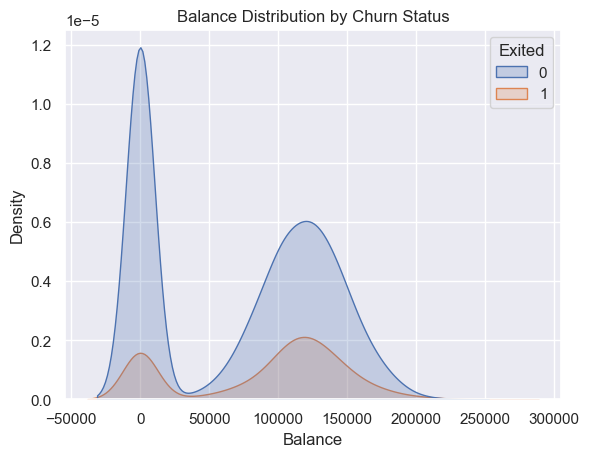

<Figure size 640x480 with 0 Axes>

In [164]:
# MAIN 
    # How does Balance interact with Churning ? 
sns.kdeplot(data=df_full, x="Balance", hue="Exited", fill=True) 
plt.title('Balance Distribution by Churn Status') 
plt.xlabel('Balance') 
plt.ylabel('Density') 
plt.show() 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Balance_churn.png')

If we suppose an effect of the Balance Status on the probability to churn, we should then see a relatively high pic of the "Exited = 1" distribution curve at a given (or mulitple) inverval of Balance. Which we do not see. We clearly see however that an important proportion of cutsomers not exiting the bank have a balance of 0. 
We then analyse the results at the country level. 

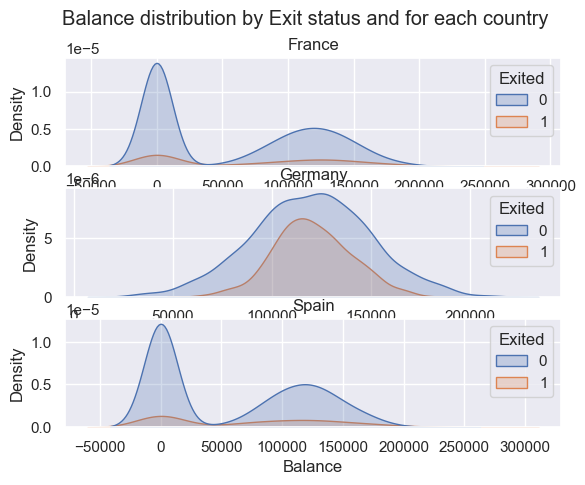

<Figure size 640x480 with 0 Axes>

In [165]:
# MAIN
    # Quick look how does Balance interact with Geography and Churn
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df_full["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df = df_full[df_full["Geography"] == country]

    sns.kdeplot(data=df, x="Balance", hue="Exited", fill=True, ax=ax[i]) 

fig.suptitle('Balance distribution by Exit status and for each country')
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Balance_Churn_country.png')

What we see at the country level is similar to what we conclude with the previous chart: having a small or big balance doesn't seem to really affect your possible future churning. - Mentionner que Germany has no customers with a null balance si sofia ne l'a pas déjà mentionné dans part 1. 

### ESTIMATED SALARY 

If the balance doesn't seem to be an important factor in the increase of churning in the bank, what about the salary? Keeping in mind that we find no strong correlation between estimated salary and balance (see. Part 1 fig ...).

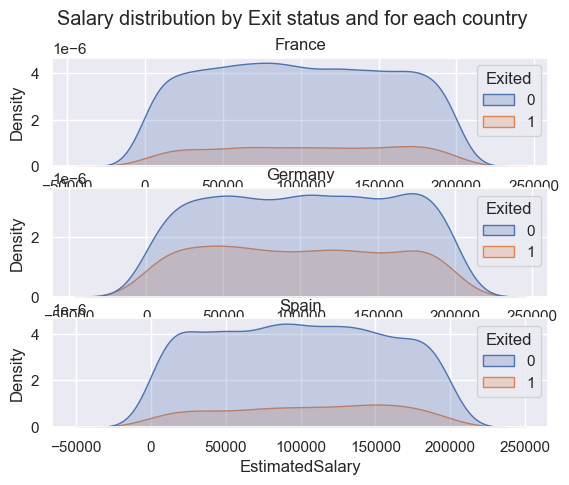

<Figure size 640x480 with 0 Axes>

In [166]:
#MAIN 
    # How does Salary interacts with churn at the country level? 

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3, 1)

for i in range (0,3):
    country = df_full["Geography"].value_counts().index[i]
    ax[i].set_title(f"{country}")

    df = df_full[df_full["Geography"] == country]

    sns.kdeplot(data=df, x="EstimatedSalary", hue="Exited", fill=True, ax=ax[i]) 

fig.suptitle('Salary distribution by Exit status and for each country')
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Salary_Churn_country.png')

Uniform distribution. Nothing to highlight

Pas vrmt de résultat significatif. Il y ac certaines hausse du nombre d'exit sur certains intervalles de salaires mais c'est très random overall (bottom mais aussi top of the salary distribution)
On peut regarder par pays.

### CREDIT SCORE

We now turn our focus to analyzing credit scores. 
Credit scores provide an interesting view of a customer's financial behavior and reliability, via factors such as payment history, outstanding debts, and credit history length. By examining these scores, we aim to identify potential trends or correlations between credit reliability and customer leaving the bank. In other words, since credit scores often reflect financial stability and borrowing capacity, they may serve as valuable indicators for assessing whether specific financial profiles are more likely to leave the bank. 

THIS FIRST CHART - should be included in part 1 à la place du graphique en bar - Sofia

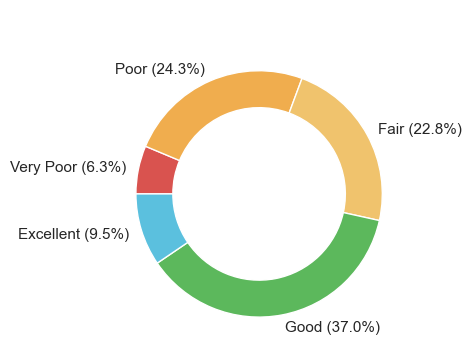

In [167]:
# first let's see if we can reproduce the chart Sofia found in google for credit score to adapt it to our data 

df_full["CreditScore"].unique()
df_full["CreditScore"].min()
df_full["CreditScore"].max()
# in our data [350 - 850]

# define the categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

df_full['Credit_Category'] = df_full['CreditScore'].apply(categorize)

# proportion of customers in each category
category_counts = df_full['Credit_Category'].value_counts(normalize=True).reindex(['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']).fillna(0)

# plot
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']
score_ranges = [300, 500, 601, 661, 781, 850]

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Convert proportions to angles (180 degrees for half-circle)
proportions = category_counts.values
angles = proportions * 180  # Half circle is 180 degrees

ax.pie(
    proportions,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, proportions)]
)

# Adjust plot limits and hide axes
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1.5])
ax.axis('off')

# Show plot
plt.show()


THE NEXT TWO CHARTS - should be put next to each other, churn VS non-churn 

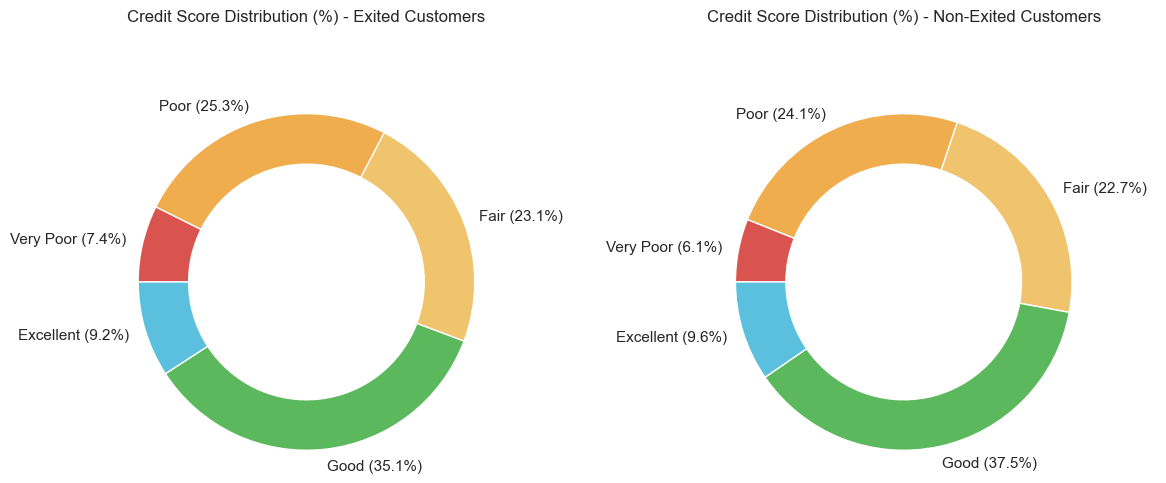

<Figure size 640x480 with 0 Axes>

In [168]:
# MAIN
    # define the Credit score categories within the dataframe
def categorize(score):
    if score < 500:
        return 'Very Poor'
    elif score < 601:
        return 'Poor'
    elif score < 661:
        return 'Fair'
    elif score < 781:
        return 'Good'
    else:
        return 'Excellent'

# Define colors and labels
labels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
colors = ['#d9534f', '#f0ad4e', '#f0c36d', '#5cb85c', '#5bc0de']

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# For exited customers
df_credit_exit = df_full.loc[df_full["Exited"] == 1].copy()
df_credit_exit['Credit_Category'] = df_credit_exit['CreditScore'].apply(categorize)
category_counts_exit = df_credit_exit['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot exited customers pie chart
axes[0].pie(
    category_counts_exit,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_exit)]
)
axes[0].set_title('Credit Score Distribution (%) - Exited Customers')
axes[0].set_xlim([-1.5, 1.5])
axes[0].set_ylim([-1, 1.5])
axes[0].axis('off')

# For non-exited customers
df_credit_non_ex = df_full.loc[df_full["Exited"] == 0].copy()
df_credit_non_ex['Credit_Category'] = df_credit_non_ex['CreditScore'].apply(categorize)
category_counts_non_ex = df_credit_non_ex['Credit_Category'].value_counts(normalize=True).reindex(labels).fillna(0)

# Plot non-exited customers pie chart
axes[1].pie(
    category_counts_non_ex,
    colors=colors,
    startangle=180,
    counterclock=False,
    wedgeprops=dict(width=0.3),
    labels=[f'{label} ({p*100:.1f}%)' for label, p in zip(labels, category_counts_non_ex)]
)
axes[1].set_title('Credit Score Distribution (%) - Non-Exited Customers')
axes[1].set_xlim([-1.5, 1.5])
axes[1].set_ylim([-1, 1.5])
axes[1].axis('off')

# Show plot
plt.tight_layout()
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/CreditScore_churn.png')

We see a slightly bigger percentage of poor and very poor customers who left the bank but it's not significant.  
Rien quand tu filtres par pays non plus

# Activity analysis

We suppose for the next part of the analysis, and given the previous results, that the bank is 10 years old, very new.  - i still think it's a strong assumption, maybe we just have data for 10 years idk if it's worth making the assumption - 
We therefore look at the effect of spending more or less years in the bank on churning. 

### YEARS SPENT IN THE BANK

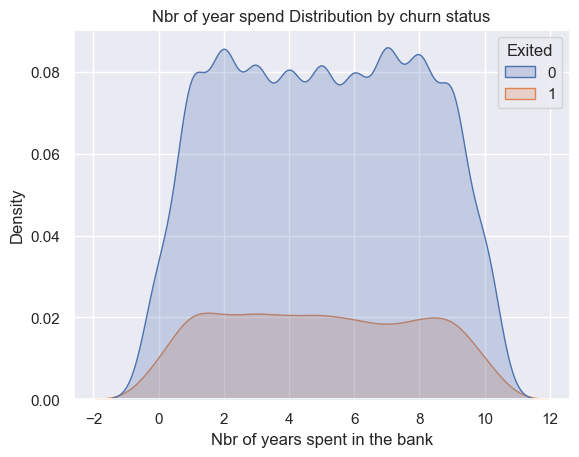

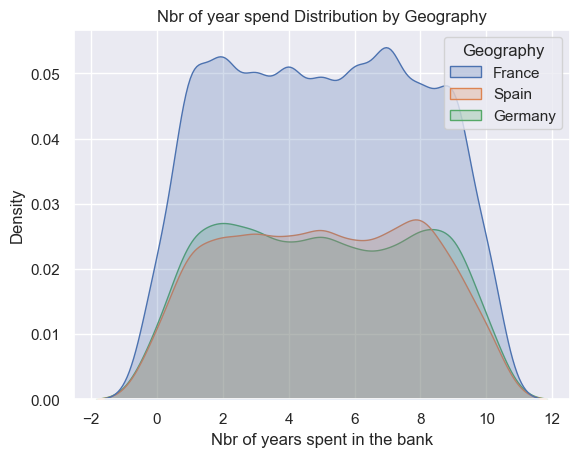

<Figure size 640x480 with 0 Axes>

In [185]:
# MAIN 
    # Does the one who exit spend more or less years in the bank ?
sns.kdeplot(data=df_full, x="Tenure", hue="Exited", fill=True) 
plt.title('Nbr of year spend Distribution by churn status') 
plt.xlabel('Nbr of years spent in the bank') 
plt.ylabel('Density') 
plt.show() 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Tenure_Churn.png')

# ANNEX + à mentionner en part 1 
    # full view per country 
sns.kdeplot(data=df_full, x="Tenure", hue="Geography", fill=True) 
plt.title('Nbr of year spend Distribution by Geography') 
plt.xlabel('Nbr of years spent in the bank') 
plt.ylabel('Density') 
plt.show() 
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Tenure_per_country.png')


Distribution is pretty homogene. 


### PRODUCTS BOUGHT

No chart to put on the main here but a sentence to add 

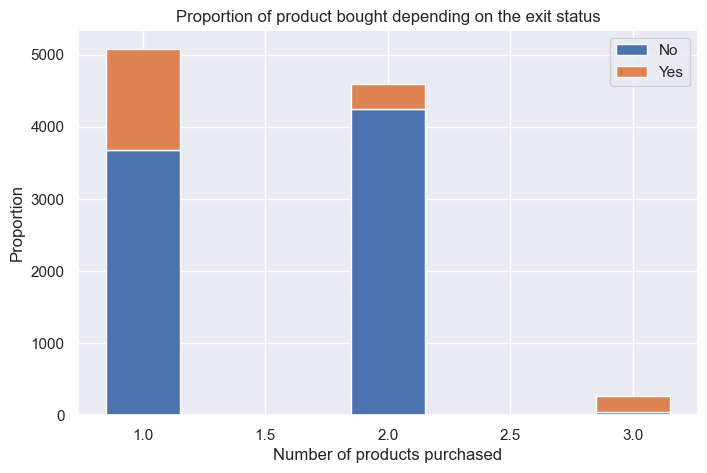

<Figure size 640x480 with 0 Axes>

In [212]:
# ANNEX 
df_prod_geo_churn = (df_full
      .groupby("NumOfProducts")["Exited"]
      .value_counts()
      #.mul()
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

ax.bar(df_prod_geo_churn.index, df_prod_geo_churn[0], label = 'No', width = 0.3) 
ax.bar(df_prod_geo_churn.index, df_prod_geo_churn[1], bottom = df_prod_geo_churn[0], label='Yes', width = 0.3)

ax.set(
    title = "Proportion of product bought depending on the exit status",
    xlabel = "Number of products purchased",
    ylabel = "Proportion"
)
ax.legend()
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Prod_Churn.png')

In [213]:
# ANNEX 
df_prod_geo_churn

Exited,0,1
NumOfProducts,,
1,3675.0,1409.0
2,4242.0,348.0
3,46.0,220.0
4,NaN,60.0


### ACTIVE MEMBER 

In [273]:
# MAIN 

     # Simple summing and percentages
country_act_counts = df_full.groupby(['Exited','IsActiveMember']).size().unstack(fill_value=0)
country_act_counts.columns = ['Recently Active Members', 'Non-Active Members']
# country_act_counts

# Calculate the total number of members per country
country_totals = country_act_counts.sum(axis=1)

# Calculate percentages for active and non-active members per country
country_act_counts['Recently Active Members (%)'] = (country_act_counts['Recently Active Members'] / country_totals) * 100
country_act_counts['Non-Active Members (%)'] = (country_act_counts['Non-Active Members'] / country_totals) * 100

country_status_percentage = country_act_counts[['Recently Active Members (%)', 'Non-Active Members (%)']]

country_status_percentage

,Recently Active Members (%),Non-Active Members (%)
Exited,,
0,44.543514,55.456486
1,63.917526,36.082474


In [274]:
     # Per country split 
# Getting the total members per country for each exit status
country_act_counts_geo = df_full.groupby(['Geography', 'Exited','IsActiveMember']).size().unstack(fill_value=0)
country_act_counts_geo.columns = ['Active Members', 'Non-Active Members']
# country_act_counts

# Calculate the total number of members per country
country_totals_geo = country_act_counts_geo.sum(axis=1)

# Calculate percentages for active and non-active members per country
country_act_counts_geo['Active Members (%)'] = (country_act_counts_geo['Active Members'] / country_totals_geo) * 100
country_act_counts_geo['Non-Active Members (%)'] = (country_act_counts_geo['Non-Active Members'] / country_totals_geo) * 100

country_status_percentage_geo = country_act_counts_geo[['Active Members (%)', 'Non-Active Members (%)']]

country_status_percentage_geo

Active Members (%)  Non-Active Members (%)
Geography Exited                                            
France    0                45.456708               54.543292
          1                63.209877               36.790123
Germany   0                43.834808               56.165192
          1                63.636364               36.363636
Spain     0                43.265504               56.734496
          1                65.859564               34.140436

double check cause first table not consistent with part 1. - but here no need for charts, let's keep tables only to change a bit 

### CREDIT CARD OWNER 

# NOTES - TO MOVE FROM PART 2 and other

### TO ADD TO THE PART 1 ? 
If we go back on the results we find for Germany: could it be that Germany has a bigger amount of female customers, and therefore a higher probability to have a bigger % of customers leaving the bank? We investigate this assumption in the follwoing chart: 

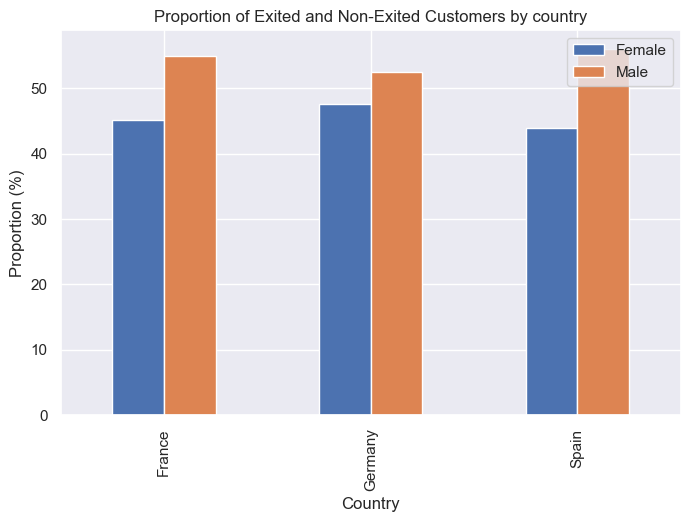

In [275]:
df_gender_country = (df_full
      .groupby("Geography")["Gender"]
      .value_counts(normalize=True)
      .mul(100)
      .round(2)
      .unstack())

fig, ax = plt.subplots(figsize = (8,5))

df_gender_country.plot(kind='bar', ax=ax)

ax.set(
    title = "Proportion of Exited and Non-Exited Customers by country",
    xlabel = "Country",
    ylabel = "Proportion (%)"
)
ax.legend()
plt.show()
# plt.tight_layout() 
# plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/PART_2_CLEAN/Country_churn_perc.png')

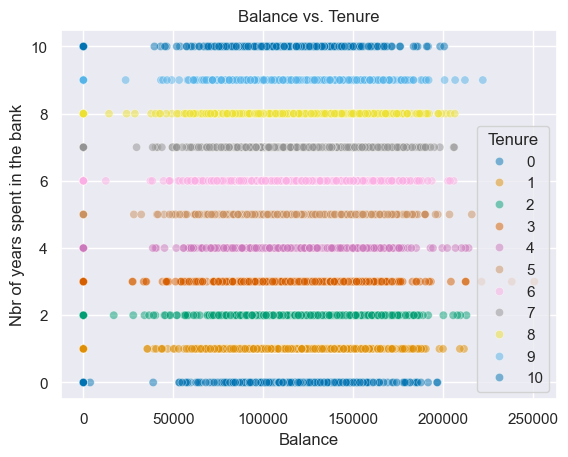

<Figure size 640x480 with 0 Axes>

In [276]:
# ANNEX + mentionner dans la partie 1 
    # Interaction btw balance and years spent in the bank 
sns.scatterplot(df_full, 
             x='Balance', 
             y='Tenure', 
             hue = 'Tenure',
             palette= sns.color_palette("colorblind", 11),
             alpha=0.5) 
plt.xlabel('Balance') 
plt.ylabel('Nbr of years spent in the bank') 
plt.title('Balance vs. Tenure') 
plt.show()
plt.tight_layout() 
plt.savefig('/Users/sarahradoui/Desktop/DAUPHINE/M2/PYTHON/python-project-Sarah-Sofia/FIG_SAVE/ANNEX/Balance_Tenure.png')

### DANS LA CCL

mentionner qu'on a pris du recul sur les resulats de notre correlation matrix. Sofia's intuition is good i think it take a binar variable 0 or 1 and if big number of 0 when controlling for churn then high correlation (A VERIFIER) 